# Emotion Classification in Sundanese Sentence

## The obligatory part

### Import the important library

In [1]:
import pandas as pd
import re

### Data path

In [2]:
data = pd.read_csv('../Dataset/data.csv')
stopwords_path = '../Dataset/stopwordv2.txt'
with open(stopwords_path, 'r') as file:
    custom_stopwords = set([line.strip() for line in file.readlines()])

In [3]:
data

,label,data
0,anger,"sok geura leungit atuh sia teh corona, matak g..."
1,anger,"Nu katoel katuhu nu nyerina kenca, goblog wasitna"
2,joy,Bingah pisan patepang sareng pangerasa. Sing k...
3,fear,asa hariwang kieu.. lalakon hirup teh asa nyor...
4,anger,"Orang mana sih anying, sampis pisan. Bunuh ae ..."
...,...,...
2093,joy,Meuni ngeunah ngabarakatak eeeuy uiiiiing....!
2094,joy,"Meuni ku endah, tebeda nami na gusti nu agung,..."
2095,joy,"meuni bungah kieu euy meunang di ngalam, nuhun..."
2096,joy,"Meuni bingah ningalna ya alloh mudah"" PaS 02 k..."


### Lowercase

In [4]:
data['lowercase'] = data['data'].str.lower()

In [5]:
data[['data', 'lowercase']]

,data,lowercase
0,"sok geura leungit atuh sia teh corona, matak g...","sok geura leungit atuh sia teh corona, matak g..."
1,"Nu katoel katuhu nu nyerina kenca, goblog wasitna","nu katoel katuhu nu nyerina kenca, goblog wasitna"
2,Bingah pisan patepang sareng pangerasa. Sing k...,bingah pisan patepang sareng pangerasa. sing k...
3,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu.. lalakon hirup teh asa nyor...
4,"Orang mana sih anying, sampis pisan. Bunuh ae ...","orang mana sih anying, sampis pisan. bunuh ae ..."
...,...,...
2093,Meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak eeeuy uiiiiing....!
2094,"Meuni ku endah, tebeda nami na gusti nu agung,...","meuni ku endah, tebeda nami na gusti nu agung,..."
2095,"meuni bungah kieu euy meunang di ngalam, nuhun...","meuni bungah kieu euy meunang di ngalam, nuhun..."
2096,"Meuni bingah ningalna ya alloh mudah"" PaS 02 k...","meuni bingah ningalna ya alloh mudah"" pas 02 k..."


### Create dictionary

In [6]:
dictionary = pd.read_csv('../Dataset/result.csv', delimiter=';')

In [7]:
dictionary

,repeated_char,kata_dasar
0,siih,sih
1,gobloggg,goblog
2,sorry,hampura
3,ninggal,ninggalkeun
4,aniing,aning
...,...,...
665,glenn,NaN
666,pisannya,pisan
667,enggal,NaN
668,eeeuy,euy


In [8]:
dictionary['kata_dasar'] = dictionary['kata_dasar'].fillna(dictionary['repeated_char'])

In [9]:
dictionary

,repeated_char,kata_dasar
0,siih,sih
1,gobloggg,goblog
2,sorry,hampura
3,ninggal,ninggalkeun
4,aniing,aning
...,...,...
665,glenn,glenn
666,pisannya,pisan
667,enggal,enggal
668,eeeuy,euy


#### Mapping dict

In [10]:
dictionary_map = dictionary.set_index('repeated_char')['kata_dasar'].to_dict()

In [11]:
dictionary_map

{'siih': 'sih',
 'gobloggg': 'goblog',
 'sorry': 'hampura',
 'ninggal': 'ninggalkeun',
 'aniing': 'aning',
 'baang': 'bang',
 'allahh': 'allah',
 'allah': 'allah',
 'anjiiiir': 'anjir',
 'meunggeus': 'meunggeus',
 'alhamdulillah': 'alhamdulillah',
 'hareeng': 'hareng',
 'alloh': 'allah',
 'plokk': 'plok',
 'sanggem': 'sanggem',
 'waas': 'was',
 'ayaan': 'ayan',
 'gustii': 'gusti',
 'essien': 'essien',
 'allhamdulillah': 'alhamdulilah',
 'aminnnnn': 'amin',
 'keadaan': 'kaayaan',
 'njirr': 'njir',
 'antepp': 'ngantep',
 'subhanalloh': 'subhanallah',
 'liburannya': 'liburannya',
 'bebelaan': 'bebelaan',
 'sllu': 'sok',
 'haduhh': 'kaduhung',
 'saacan': 'sacan',
 'ee': 'ee',
 'nyeriiiii': 'nyeri',
 'aamiin': 'amin',
 'teunggeul': 'teunggeulan',
 'aaaah': 'ah',
 'liverpool': 'liverpool',
 'syukuranna': 'syukur',
 'mm': 'mm',
 'wee': 'wee',
 'beuuuhhh': 'beuh',
 'alhamdulilla': 'alhamdulilah',
 'nggeus': 'sanggeus',
 'ngajenggut': 'ngajenggut',
 'niis': 'niis',
 'meninggal': 'ajal',
 'penga

In [12]:
data['mapping_dict'] = data['lowercase'].replace(dictionary_map, regex=True)

In [13]:
data

,label,data,lowercase,mapping_dict
0,anger,"sok geura leungit atuh sia teh corona, matak g...","sok geura leungit atuh sia teh corona, matak g...","sok geura leungit atuh sia teh corona, matak g..."
1,anger,"Nu katoel katuhu nu nyerina kenca, goblog wasitna","nu katoel katuhu nu nyerina kenca, goblog wasitna","nu katoel katuhu nu nyerina kenca, goblog wasitna"
2,joy,Bingah pisan patepang sareng pangerasa. Sing k...,bingah pisan patepang sareng pangerasa. sing k...,bingah pisan patepang sareng pangerasa. sing k...
3,fear,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu.. lalakon hirup teh asa nyor...
4,anger,"Orang mana sih anying, sampis pisan. Bunuh ae ...","orang mana sih anying, sampis pisan. bunuh ae ...","orang mana sih anying, sampis pisan. bunuh ae ..."
...,...,...,...,...
2093,joy,Meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak euy uing....!
2094,joy,"Meuni ku endah, tebeda nami na gusti nu agung,...","meuni ku endah, tebeda nami na gusti nu agung,...","meuni ku endah, tebeda nami na gusti nu agung,..."
2095,joy,"meuni bungah kieu euy meunang di ngalam, nuhun...","meuni bungah kieu euy meunang di ngalam, nuhun...","meuni bungah kieu euy meunang di ngalam, nuhun..."
2096,joy,"Meuni bingah ningalna ya alloh mudah"" PaS 02 k...","meuni bingah ningalna ya alloh mudah"" pas 02 k...","meuni bingah ningalna ya kabehah mudah"" pas 02..."


### Remove numbering (non alphabet)

In [14]:
data['remove_non_alphabet'] = data['mapping_dict'].apply(lambda x: re.sub(r'[^a-z]', ' ', x))

In [15]:
data

,label,data,lowercase,mapping_dict,remove_non_alphabet
0,anger,"sok geura leungit atuh sia teh corona, matak g...","sok geura leungit atuh sia teh corona, matak g...","sok geura leungit atuh sia teh corona, matak g...",sok geura leungit atuh sia teh corona matak g...
1,anger,"Nu katoel katuhu nu nyerina kenca, goblog wasitna","nu katoel katuhu nu nyerina kenca, goblog wasitna","nu katoel katuhu nu nyerina kenca, goblog wasitna",nu katoel katuhu nu nyerina kenca goblog wasitna
2,joy,Bingah pisan patepang sareng pangerasa. Sing k...,bingah pisan patepang sareng pangerasa. sing k...,bingah pisan patepang sareng pangerasa. sing k...,bingah pisan patepang sareng pangerasa sing k...
3,fear,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu lalakon hirup teh asa nyor...
4,anger,"Orang mana sih anying, sampis pisan. Bunuh ae ...","orang mana sih anying, sampis pisan. bunuh ae ...","orang mana sih anying, sampis pisan. bunuh ae ...",orang mana sih anying sampis pisan bunuh ae ...
...,...,...,...,...,...
2093,joy,Meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak euy uing....!,meuni ngeunah ngabarakatak euy uing
2094,joy,"Meuni ku endah, tebeda nami na gusti nu agung,...","meuni ku endah, tebeda nami na gusti nu agung,...","meuni ku endah, tebeda nami na gusti nu agung,...",meuni ku endah tebeda nami na gusti nu agung ...
2095,joy,"meuni bungah kieu euy meunang di ngalam, nuhun...","meuni bungah kieu euy meunang di ngalam, nuhun...","meuni bungah kieu euy meunang di ngalam, nuhun...",meuni bungah kieu euy meunang di ngalam nuhun...
2096,joy,"Meuni bingah ningalna ya alloh mudah"" PaS 02 k...","meuni bingah ningalna ya alloh mudah"" pas 02 k...","meuni bingah ningalna ya kabehah mudah"" pas 02...",meuni bingah ningalna ya kabehah mudah pas ...


In [16]:
data.loc[2096]

label                                                                joy
data                   Meuni bingah ningalna ya alloh mudah" PaS 02 k...
lowercase              meuni bingah ningalna ya alloh mudah" pas 02 k...
mapping_dict           meuni bingah ningalna ya kabehah mudah" pas 02...
remove_non_alphabet    meuni bingah ningalna ya kabehah mudah  pas   ...
Name: 2096, dtype: object

### Remove whitespaces

In [17]:
data['no_whitespace'] = data['remove_non_alphabet'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [18]:
data.loc[2096]

label                                                                joy
data                   Meuni bingah ningalna ya alloh mudah" PaS 02 k...
lowercase              meuni bingah ningalna ya alloh mudah" pas 02 k...
mapping_dict           meuni bingah ningalna ya kabehah mudah" pas 02...
remove_non_alphabet    meuni bingah ningalna ya kabehah mudah  pas   ...
no_whitespace          meuni bingah ningalna ya kabehah mudah pas ken...
Name: 2096, dtype: object

### Remove punctuation

In [19]:
data['no_punctuation'] = data['no_whitespace'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [20]:
data

,label,data,lowercase,mapping_dict,remove_non_alphabet,no_whitespace,no_punctuation
0,anger,"sok geura leungit atuh sia teh corona, matak g...","sok geura leungit atuh sia teh corona, matak g...","sok geura leungit atuh sia teh corona, matak g...",sok geura leungit atuh sia teh corona matak g...,sok geura leungit atuh sia teh corona matak ge...,sok geura leungit atuh sia teh corona matak ge...
1,anger,"Nu katoel katuhu nu nyerina kenca, goblog wasitna","nu katoel katuhu nu nyerina kenca, goblog wasitna","nu katoel katuhu nu nyerina kenca, goblog wasitna",nu katoel katuhu nu nyerina kenca goblog wasitna,nu katoel katuhu nu nyerina kenca goblog wasitna,nu katoel katuhu nu nyerina kenca goblog wasitna
2,joy,Bingah pisan patepang sareng pangerasa. Sing k...,bingah pisan patepang sareng pangerasa. sing k...,bingah pisan patepang sareng pangerasa. sing k...,bingah pisan patepang sareng pangerasa sing k...,bingah pisan patepang sareng pangerasa sing ka...,bingah pisan patepang sareng pangerasa sing ka...
3,fear,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu lalakon hirup teh asa nyor...,asa hariwang kieu lalakon hirup teh asa nyoran...,asa hariwang kieu lalakon hirup teh asa nyoran...
4,anger,"Orang mana sih anying, sampis pisan. Bunuh ae ...","orang mana sih anying, sampis pisan. bunuh ae ...","orang mana sih anying, sampis pisan. bunuh ae ...",orang mana sih anying sampis pisan bunuh ae ...,orang mana sih anying sampis pisan bunuh ae la...,orang mana sih anying sampis pisan bunuh ae la...
...,...,...,...,...,...,...,...
2093,joy,Meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak euy uing....!,meuni ngeunah ngabarakatak euy uing,meuni ngeunah ngabarakatak euy uing,meuni ngeunah ngabarakatak euy uing
2094,joy,"Meuni ku endah, tebeda nami na gusti nu agung,...","meuni ku endah, tebeda nami na gusti nu agung,...","meuni ku endah, tebeda nami na gusti nu agung,...",meuni ku endah tebeda nami na gusti nu agung ...,meuni ku endah tebeda nami na gusti nu agung d...,meuni ku endah tebeda nami na gusti nu agung d...
2095,joy,"meuni bungah kieu euy meunang di ngalam, nuhun...","meuni bungah kieu euy meunang di ngalam, nuhun...","meuni bungah kieu euy meunang di ngalam, nuhun...",meuni bungah kieu euy meunang di ngalam nuhun...,meuni bungah kieu euy meunang di ngalam nuhun ...,meuni bungah kieu euy meunang di ngalam nuhun ...
2096,joy,"Meuni bingah ningalna ya alloh mudah"" PaS 02 k...","meuni bingah ningalna ya alloh mudah"" pas 02 k...","meuni bingah ningalna ya kabehah mudah"" pas 02...",meuni bingah ningalna ya kabehah mudah pas ...,meuni bingah ningalna ya kabehah mudah pas ken...,meuni bingah ningalna ya kabehah mudah pas ken...


### Apply standardized words

#### Cosine similarity to correct the words

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [22]:
standardized_word = pd.read_csv('../Dataset/standardized_word.csv')

In [23]:
standardized_list = standardized_word['standard'].tolist()

In [24]:
vectorizer = TfidfVectorizer()
standardized_vector = vectorizer.fit_transform(standardized_list)

In [25]:
def optimized_standardize_words(text, standardized_list, standardized_vectors):
    words = text.split()
    standardized_text = []
    
    for word in words:
        word_vector = vectorizer.transform([word])
        
        similarities = cosine_similarity(word_vector, standardized_vectors).flatten()
        
        max_similarity = max(similarities)
        if max_similarity > 0.7:
            best_match = standardized_list[np.argmax(similarities)]
        else:
            best_match = word
        
        standardized_text.append(best_match)
    
    return " ".join(standardized_text)

In [26]:
data['standardized_word'] = data['no_punctuation'].apply(
    lambda x: optimized_standardize_words(x, standardized_list, standardized_vector)
)

In [27]:
data.loc[0]

label                                                              anger
data                   sok geura leungit atuh sia teh corona, matak g...
lowercase              sok geura leungit atuh sia teh corona, matak g...
mapping_dict           sok geura leungit atuh sia teh corona, matak g...
remove_non_alphabet    sok geura leungit atuh sia teh corona  matak g...
no_whitespace          sok geura leungit atuh sia teh corona matak ge...
no_punctuation         sok geura leungit atuh sia teh corona matak ge...
standardized_word      sok geura-giru leungit atuh sia teh corona mat...
Name: 0, dtype: object

### Tokenizing

In [28]:
data['tokenized'] = data['standardized_word'].apply(lambda x: x.split())

In [29]:
data

,label,data,lowercase,mapping_dict,remove_non_alphabet,no_whitespace,no_punctuation,standardized_word,tokenized
0,anger,"sok geura leungit atuh sia teh corona, matak g...","sok geura leungit atuh sia teh corona, matak g...","sok geura leungit atuh sia teh corona, matak g...",sok geura leungit atuh sia teh corona matak g...,sok geura leungit atuh sia teh corona matak ge...,sok geura leungit atuh sia teh corona matak ge...,sok geura-giru leungit atuh sia teh corona mat...,"[sok, geura-giru, leungit, atuh, sia, teh, cor..."
1,anger,"Nu katoel katuhu nu nyerina kenca, goblog wasitna","nu katoel katuhu nu nyerina kenca, goblog wasitna","nu katoel katuhu nu nyerina kenca, goblog wasitna",nu katoel katuhu nu nyerina kenca goblog wasitna,nu katoel katuhu nu nyerina kenca goblog wasitna,nu katoel katuhu nu nyerina kenca goblog wasitna,nu boga katoel katuhu nu boga nyerina kenca go...,"[nu, boga, katoel, katuhu, nu, boga, nyerina, ..."
2,joy,Bingah pisan patepang sareng pangerasa. Sing k...,bingah pisan patepang sareng pangerasa. sing k...,bingah pisan patepang sareng pangerasa. sing k...,bingah pisan patepang sareng pangerasa sing k...,bingah pisan patepang sareng pangerasa sing ka...,bingah pisan patepang sareng pangerasa sing ka...,bingah pisan patepang sareng pangerasa sing sa...,"[bingah, pisan, patepang, sareng, pangerasa, s..."
3,fear,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu lalakon hirup teh asa nyor...,asa hariwang kieu lalakon hirup teh asa nyoran...,asa hariwang kieu lalakon hirup teh asa nyoran...,asa hariwang kieu lalakon hirup teh asa nyoran...,"[asa, hariwang, kieu, lalakon, hirup, teh, asa..."
4,anger,"Orang mana sih anying, sampis pisan. Bunuh ae ...","orang mana sih anying, sampis pisan. bunuh ae ...","orang mana sih anying, sampis pisan. bunuh ae ...",orang mana sih anying sampis pisan bunuh ae ...,orang mana sih anying sampis pisan bunuh ae la...,orang mana sih anying sampis pisan bunuh ae la...,orang mana sih anying sampis pisan bunuh ae la...,"[orang, mana, sih, anying, sampis, pisan, bunu..."
...,...,...,...,...,...,...,...,...,...
2093,joy,Meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak euy uing....!,meuni ngeunah ngabarakatak euy uing,meuni ngeunah ngabarakatak euy uing,meuni ngeunah ngabarakatak euy uing,meuni ngeunah ngabarakatak euy uing,"[meuni, ngeunah, ngabarakatak, euy, uing]"
2094,joy,"Meuni ku endah, tebeda nami na gusti nu agung,...","meuni ku endah, tebeda nami na gusti nu agung,...","meuni ku endah, tebeda nami na gusti nu agung,...",meuni ku endah tebeda nami na gusti nu agung ...,meuni ku endah tebeda nami na gusti nu agung d...,meuni ku endah tebeda nami na gusti nu agung d...,meuni ku endah tebeda nami na gusti nu boga ag...,"[meuni, ku, endah, tebeda, nami, na, gusti, nu..."
2095,joy,"meuni bungah kieu euy meunang di ngalam, nuhun...","meuni bungah kieu euy meunang di ngalam, nuhun...","meuni bungah kieu euy meunang di ngalam, nuhun...",meuni bungah kieu euy meunang di ngalam nuhun...,meuni bungah kieu euy meunang di ngalam nuhun ...,meuni bungah kieu euy meunang di ngalam nuhun ...,meuni bungah kieu euy meunang di ngalam hatur ...,"[meuni, bungah, kieu, euy, meunang, di, ngalam..."
2096,joy,"Meuni bingah ningalna ya alloh mudah"" PaS 02 k...","meuni bingah ningalna ya alloh mudah"" pas 02 k...","meuni bingah ningalna ya kabehah mudah"" pas 02...",meuni bingah ningalna ya kabehah mudah pas ...,meuni bingah ningalna ya kabehah mudah pas ken...,meuni bingah ningalna ya kabehah mudah pas ken...,meuni bingah ningalna ya kabehah mudah pas ken...,"[meuni, bingah, ningalna, ya, kabehah, mudah, ..."


## Model LSTM

### Import the important library

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GaussianNoise
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight


### Define variable

In [43]:
texts = data['tokenized'].tolist()
labels = data['label'].tolist()

In [44]:
len(texts), len(labels)

(2098, 2098)

In [45]:
all_words = [word for tokens in texts for word in tokens]
unique_words = list(set(all_words))
word_index = {word: i + 1 for i, word in enumerate(unique_words)}

In [46]:
sequences = [[word_index[word] for word in tokens if word in word_index] for tokens in texts]

In [47]:
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [48]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

#### Weighted classes

In [50]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

In [51]:
class_weight_dict

{0: np.float64(1.0256723716381417),
 1: np.float64(1.0409429280397022),
 2: np.float64(0.9710648148148148),
 3: np.float64(0.966589861751152)}

In [52]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(len(set(encoded_labels)), activation='softmax'))

/Users/mac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [53]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [56]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping, reduce_lr], class_weight=class_weight_dict)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.2261 - loss: 8.7170 - val_accuracy: 0.2143 - val_loss: 8.0969 - learning_rate: 1.0000e-04
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.2419 - loss: 7.9216 - val_accuracy: 0.2143 - val_loss: 7.3810 - learning_rate: 1.0000e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.2709 - loss: 7.2225 - val_accuracy: 0.1964 - val_loss: 6.7435 - learning_rate: 1.0000e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.2010 - loss: 6.6068 - val_accuracy: 0.2143 - val_loss: 6.1738 - learning_rate: 1.0000e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.2404 - loss: 6.0506 - val_accuracy: 0.1964 - val_loss: 5.6644 - learning_rate: 1.0000e-04
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.2286 - loss: 5.5524 - val_accuracy: 0.1964 - val_loss: 5.2105 - learning_rate: 1.0000e-04
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0

### Result

#### Accuracy test

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test: {accuracy:.2%}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2625 - loss: 1.4294
Test: 25.95%


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

           0       0.26      1.00      0.41       109
           1       0.00      0.00      0.00       108
           2       0.00      0.00      0.00       107
           3       0.00      0.00      0.00        96

    accuracy                           0.26       420
   macro avg       0.06      0.25      0.10       420
weighted avg       0.07      0.26      0.11       420



/Users/mac/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

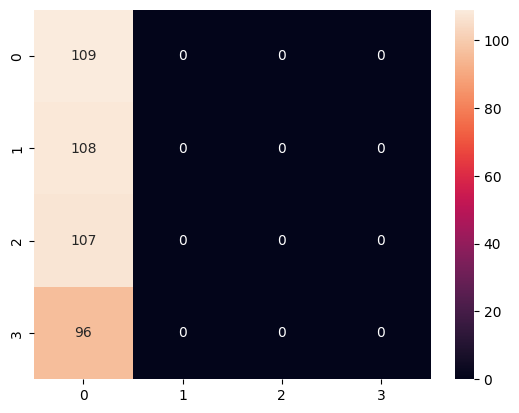

In [65]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d')

#### Visualization accuracy

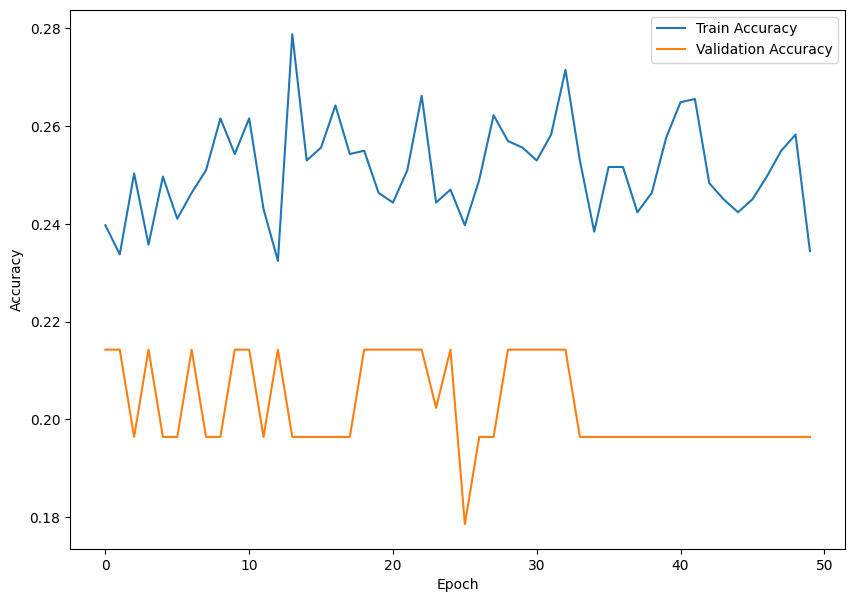

In [66]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Visualization loss

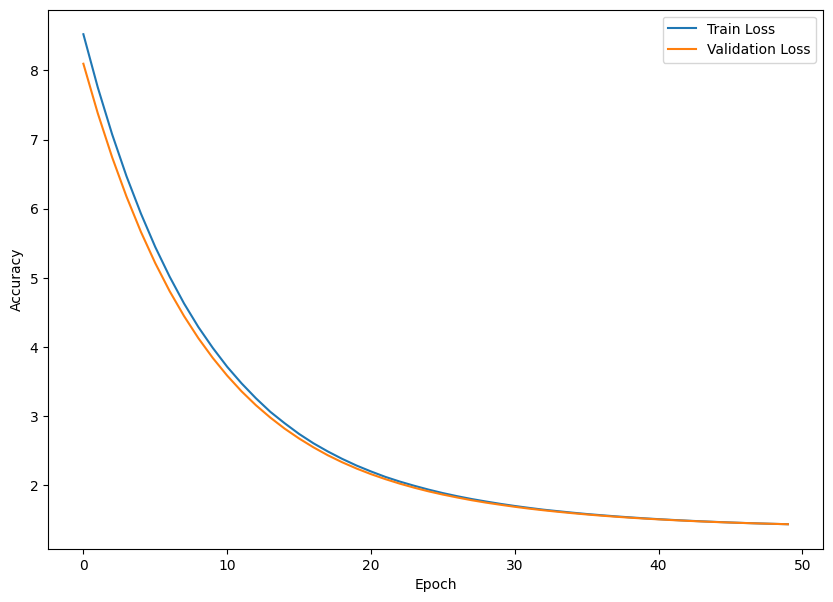

In [67]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model BERT

### Import the important library

In [69]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#### Check the device cpu

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [71]:
text_column = 'standardized_word'
label_column = 'label'

In [73]:
label_mapping = {label: idx for idx, label in enumerate(data[label_column].unique())}
data['label_encoded'] = data[label_column].map(label_mapping)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    data[text_column].values,
    data['label_encoded'].values,
    test_size=0.2,
    random_state=42
)

In [75]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [76]:
def encode_texts(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

In [77]:
X_train_encoded = encode_texts(X_train, tokenizer)
X_test_encoded = encode_texts(X_test, tokenizer)

In [78]:
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

In [79]:
train_dataset = TensorDataset(X_train_encoded['input_ids'], X_train_encoded['attention_mask'], y_train_tensor)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=16)

In [80]:
test_dataset = TensorDataset(X_test_encoded['input_ids'], X_test_encoded['attention_mask'], y_test_tensor)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=16)

In [81]:
modelv1 = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))
modelv1 = modelv1.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
optimizer = AdamW(modelv1.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3

/Users/mac/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [83]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [84]:
def train_model(modelv1, dataloader, optimizer, scheduler, epochs=3):
    modelv1.train()
    for epoch in range(epochs):
        total_loss = 0
        print(f'Epoch {epoch + 1}/{epochs}')
        for step, batch in enumerate(dataloader):
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            modelv1.zero_grad()
            outputs = modelv1(batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(modelv1.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        print(f'Average training loss: {avg_loss:.4f}')
train_model(modelv1, train_dataloader, optimizer, scheduler, epochs=3)

Epoch 1/3
Average training loss: 1.2813
Epoch 2/3
Average training loss: 0.8503
Epoch 3/3
Average training loss: 0.5547


In [85]:
def evaluate_model(modelv1, dataloader):
    modelv1.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            outputs = modelv1(batch_input_ids, attention_mask=batch_attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())
    return true_labels, predictions

In [86]:
true_labels, predictions = evaluate_model(modelv1, test_dataloader)

### Result

In [87]:
print(classification_report(true_labels, predictions))
print(f'Accuracy: {accuracy_score(true_labels, predictions):.2%}')

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       109
           1       0.91      0.78      0.84       107
           2       0.86      0.84      0.85       108
           3       0.71      0.75      0.73        96

    accuracy                           0.83       420
   macro avg       0.83      0.83      0.83       420
weighted avg       0.84      0.83      0.83       420

Accuracy: 83.10%


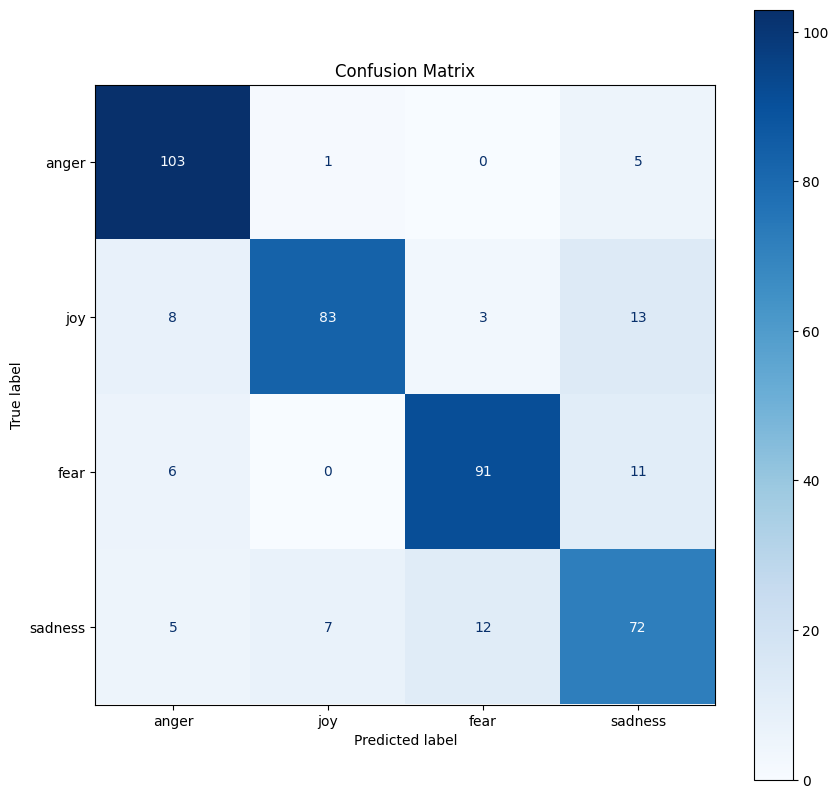

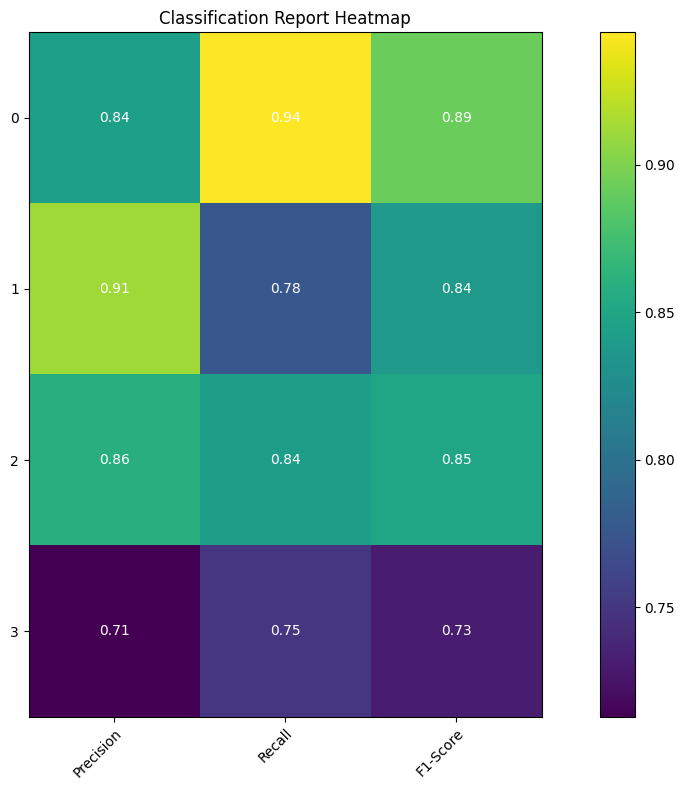

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_labels, predictions, output_dict=True)
categories = list(report.keys())[:-3]

report_values = np.array([[report[cat]['precision'], report[cat]['recall'], report[cat]['f1-score']] for cat in categories])
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(report_values, cmap='viridis')

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(len(categories)))
ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
ax.set_yticklabels(categories)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(categories)):
    for j in range(3):
        text = ax.text(j, i, f"{report_values[i, j]:.2f}", ha="center", va="center", color="white")

ax.set_title("Classification Report Heatmap")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


#### Export model BERT